<a href="https://colab.research.google.com/github/Teasotea/Age-Rate-Classifier-NLP/blob/main/dense_age_rate_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Dense Age Rate Classifier



###TODO: Build a dense neural net to classify  movies by their age rate.

In [174]:
pip install geotext


In [305]:
import os
import io
import json

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import model_selection
from sklearn.preprocessing import LabelEncoder 
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from tensorflow.keras.preprocessing.sequence import pad_sequences 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.layers import Embedding 
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.preprocessing.text import Tokenizer

import nltk
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import names
from nltk.corpus import stopwords
from nltk.stem.porter import *
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('names')
from geotext import GeoText

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package names to /root/nltk_data...
[nltk_data]   Package names is already up-to-date!


#Load Data

In [306]:
dataset_url = 'https://raw.githubusercontent.com/Teasotea/Age-Rate-Classifier-NLP/main/IMDB_data.csv'
df = pd.read_csv(dataset_url)
df.head()

,Unnamed: 0,Name of movie,Description,Age rate,Year,Runtime,Genre
0,0,The Shawshank Redemption,Two imprisoned men bond over a number of years...,R,1994,142,Drama
1,1,The Godfather,The Godfather follows Vito Corleone Don of the...,R,1972,175,"Crime, Drama"
2,2,Pulp Fiction,"The lives of two mob hitmen, a boxer, a gangst...",R,1994,154,"Crime, Drama"
3,3,The Godfather: Part II,The early life and career of Vito Corleone in ...,R,1974,202,"Crime, Drama"
4,4,Inception,A thief who steals corporate secrets through t...,PG-13,2010,148,"Action, Adventure, Sci-Fi"


In [307]:
is_r = list()
for i in df['Age rate']:
  if i=='R': is_r.append(1)
  else: is_r.append(0)

#Remove stopwords and punctuation

In [308]:
#define stop words: english stop words, numbers, male and female names
numbers = ['one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'ten', 'eleven', 'twelve', 	'thirteen', 'fourteen', 'fifteen', 
'sixteen', 'seventeen', 'eighteen', 'nineteen', 'twenty', 'thirty', 'forty', 'fifty', 'sixty', 'seventy', 'eighty', 'ninety', 'hundred']
stpwrds = stopwords.words('english') + [i.lower() for i in names.words('male.txt') + names.words('female.txt')] + numbers
#print(stpwrds.count('into'))
data = [i.lower() for i in df['Description']]
data2 = []

#remove city names from description
for i in range(len(df['Description'])):
  places = GeoText(df['Description'][i])
  if places.cities != []:
    for j in places.cities:
      data[i] = data[i].replace(j.lower(), '')

for i in data:
  #remove punctuation and split
  tr= str.maketrans(dict.fromkeys(string.punctuation))
  new_i = i.translate(tr)
  descr = new_i.split(sep=' ')

  #remove stop words or numbers
  for k in range(10):
    for j in descr:
      if j in stpwrds or j!= '' and j[0].isdigit():
        descr.remove(j)
    if "" in descr:
      descr.remove("")
  data2.append(descr)

print(df['Description'][3])
print(data2[3])


The early life and career of Vito Corleone in 1920s New York City is portrayed, while his son, Michael, expands and tightens his grip on the family crime syndicate.
['early', 'life', 'career', 'corleone', 'city', 'portrayed', 'expands', 'tightens', 'grip', 'family', 'crime', 'syndicate']


#Stem words

In [309]:
stemmer = PorterStemmer()
for i in range(len(data2)):
  data2[i] = [stemmer.stem(w.lower()) for w in data2[i]]
print(data2[3])

['earli', 'life', 'career', 'corleon', 'citi', 'portray', 'expand', 'tighten', 'grip', 'famili', 'crime', 'syndic']


In [310]:
short_df = pd.DataFrame(list(zip(data2, is_r)),
               columns =['description', 'age rate'])
short_df.head()
#with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#     print(short_df)

,description,age rate
0,"[imprison, men, bond, number, year, find, sola...",1
1,"[godfath, follow, corleon, corleon, famili, pa...",1
2,"[live, mob, hitmen, boxer, gangster, wife, pai...",1
3,"[earli, life, career, corleon, citi, portray, ...",1
4,"[thief, steal, corpor, secret, use, dreamshar,...",0


# Hyperparameters


In [311]:
# output directory name:
output_dir = 'model_output/dense'

embedding_dim = 64
max_features=10000
maxlen=25

####
# training:
epochs = 6 #4
batch_size = 32#784

# vector-space embedding: 
n_dim = 64
n_unique_words = 5000 # as per Maas et al. (2011); may not be optimal
#n_words_to_skip = 50 # ditto
max_decription_length = 100 #max_review_length (amount of tokens(words))
pad_type = trunc_type = 'pre' #could be 'post'

# neural network architecture: 
n_dense = 64 #neurons
dropout = 0.5 #drop 50% of neurons 





# Tokenizer

In [312]:
#tokenizer of descriptions
t  = Tokenizer(num_words=max_features)
t.fit_on_texts([x for x in short_df['description']])
print(len(t.word_index))
with io.open(output_dir+'/tokenizer.json', 'w',encoding='utf-8', ) as f:
    f.write(json.dumps(t.to_json(),ensure_ascii=False))
vocab_size = len(t.word_index) + 1
num_categories = 1


3541


In [262]:


descr_sequences = t.texts_to_sequences([x for x in np.array(short_df['description'])])
descr_sequences = tf.keras.preprocessing.sequence.pad_sequences(descr_sequences, maxlen=maxlen)
print(descr_sequences[0])
print('sequences : ',descr_sequences,'\n')
print('word_index : ',t.word_index)
print(np.array(descr_sequences))

[   0    0    0    0    0    0    0    0    0    0    0    0    0  518
  110  101  688   23    1  970  689  971  267 1566 1567]
sequences :  [[   0    0    0 ...  267 1566 1567]
 [   0    0    0 ...   11  520 1569]
 [   0    0    0 ...  198  521  971]
 ...
 [   0    0    0 ...  465 3538  132]
 [   0    0    0 ...  411 3539  567]
 [   0    0    0 ...  969  169  511]] 

word_index :  {'find': 1, 'must': 2, 'young': 3, 'life': 4, 'man': 5, 'world': 6, 'group': 7, 'becom': 8, 'new': 9, 'help': 10, 'famili': 11, 'friend': 12, 'discov': 13, 'citi': 14, 'mysteri': 15, 'kill': 16, 'agent': 17, 'live': 18, 'forc': 19, 'tri': 20, 'murder': 21, 'team': 22, 'year': 23, 'save': 24, 'take': 25, 'set': 26, 'woman': 27, 'father': 28, 'time': 29, 'get': 30, 'human': 31, 'fight': 32, 'back': 33, 'school': 34, 'return': 35, 'home': 36, 'make': 37, 'stop': 38, 'use': 39, 'killer': 40, 'former': 41, 'evil': 42, 'come': 43, 'travel': 44, 'investig': 45, 'death': 46, 'go': 47, 'power': 48, 'girl': 49, 'plan'

#Split data into train and test 

In [313]:
X_train, X_test, y_train, y_test = train_test_split(descr_sequences, short_df['age rate'], test_size=0.1, random_state=42)


print(np.array(X_train))

[[   0    0    0 ... 1271   24  223]
 [   0    0  124 ... 1840   46  141]
 [   0    0    0 ... 1053  216 1694]
 ...
 [   0    0    0 ...  892  121  657]
 [   0    0    0 ...  940  580 1210]
 [   0    0    0 ...  121 1824   49]]


In [314]:
l = len(X_train[363])
print(l)

25


# Model and Train

In [315]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Embedding(input_dim=vocab_size,
                           output_dim=embedding_dim,
                           input_length=maxlen),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(2000,activation='relu'),
  tf.keras.layers.Dense(500,activation='relu'),
  tf.keras.layers.Dense(100,activation='relu'),
  tf.keras.layers.Dense(num_categories, activation=tf.nn.sigmoid)
])

model.compile(optimizer='nadam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

modelcheckpoint = tf.keras.callbacks.ModelCheckpoint(filepath=output_dir+
                                  "/weights.{epoch:02d}.hdf5")

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 25, 64)            226688    
                                                                 
 flatten_5 (Flatten)         (None, 1600)              0         
                                                                 
 dense_20 (Dense)            (None, 2000)              3202000   
                                                                 
 dense_21 (Dense)            (None, 500)               1000500   
                                                                 
 dense_22 (Dense)            (None, 100)               50100     
                                                                 
 dense_23 (Dense)            (None, 1)                 101       
                                                                 
Total params: 4,479,389
Trainable params: 4,479,389
No

In [316]:
#embedding level
n_dim, n_unique_words, n_dim*n_unique_words

(64, 5000, 320000)

In [317]:
#flatten
max_decription_length, n_dim, n_dim*max_decription_length

(100, 64, 6400)

In [318]:
#dense
n_dense, n_dim*max_decription_length*n_dense+n_dense #weights + biases

(64, 409664)

In [319]:
#output
n_dense + 1

65

#Configure model

In [320]:
model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy'])


modelcheckpoint = ModelCheckpoint(filepath=output_dir+
                                  "/weights.{epoch:02d}.hdf5")
callbacks=[modelcheckpoint]



if not os.path.exists(output_dir):
    os.makedirs(output_dir)

model.fit(X_train.astype('float32'),
          np.array(y_train).astype('float32').reshape((-1,1)), 
          batch_size=batch_size, epochs=epochs, verbose=1, 
          validation_data=(X_test.astype('float32'), 
          np.array(y_test).astype('float32').reshape((-1,1))), callbacks=callbacks)

Epoch 1/6
23/23 [==============================] - 4s 101ms/step - loss: 0.6854 - accuracy: 0.5567 - val_loss: 0.6852 - val_accuracy: 0.5443
Epoch 2/6
23/23 [==============================] - 2s 95ms/step - loss: 0.5235 - accuracy: 0.7266 - val_loss: 0.9460 - val_accuracy: 0.5949
Epoch 3/6
23/23 [==============================] - 2s 94ms/step - loss: 0.0412 - accuracy: 0.9873 - val_loss: 2.0398 - val_accuracy: 0.4937
Epoch 4/6
23/23 [==============================] - 2s 94ms/step - loss: 0.0035 - accuracy: 0.9986 - val_loss: 1.3339 - val_accuracy: 0.6582
Epoch 5/6
23/23 [==============================] - 2s 92ms/step - loss: 2.9640e-04 - accuracy: 1.0000 - val_loss: 1.3934 - val_accuracy: 0.6456
Epoch 6/6
23/23 [==============================] - 2s 94ms/step - loss: 1.2602e-04 - accuracy: 1.0000 - val_loss: 1.3978 - val_accuracy: 0.6962


In [321]:
score = model.evaluate(np.array(X_test), np.array(y_test)) 

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

3/3 [==============================] - 0s 11ms/step - loss: 1.3978 - accuracy: 0.6962
Test Score: 1.3978180885314941
Test Accuracy: 0.6962025165557861


# Accuracy by Label

In [322]:
model.load_weights(output_dir+"/weights.02.hdf5") # NOT zero-indexed

In [323]:
y_hat = model.predict(X_test)

In [324]:
len(y_hat)

79

In [325]:
y_hat[3]

array([0.11950082], dtype=float32)

In [326]:
print(np.array(y_test)[3])

1


In [327]:
print(type(y_hat))

<class 'numpy.ndarray'>


In [329]:
pct_auc = roc_auc_score(y_test, y_hat)*100.0
"{:0.2f}".format(pct_auc)

'64.47'

In [330]:
float_y_hat = []
for y in y_hat:
    float_y_hat.append(y[0])

In [377]:
ydf = pd.DataFrame(list(zip(float_y_hat, y_test)), columns=['y_hat', 'y'])

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
     print(ydf)

       y_hat  y
0   0.176884  0
1   0.005274  0
2   0.761301  1
3   0.119501  1
4   0.080103  0
5   0.262201  0
6   0.054166  0
7   0.019870  0
8   0.038521  1
9   0.060719  1
10  0.643186  0
11  0.091632  1
12  0.143416  1
13  0.269978  1
14  0.075831  0
15  0.566653  1
16  0.552250  1
17  0.137174  0
18  0.054910  0
19  0.076055  0
20  0.065984  0
21  0.230226  0
22  0.054895  1
23  0.158809  1
24  0.158608  1
25  0.439810  1
26  0.162589  0
27  0.093510  0
28  0.335297  1
29  0.109020  1
30  0.061583  0
31  0.050390  1
32  0.149148  0
33  0.089358  0
34  0.071658  1
35  0.177706  1
36  0.357569  1
37  0.483133  1
38  0.245234  0
39  0.244338  1
40  0.031822  1
41  0.049226  1
42  0.050477  0
43  0.394927  0
44  0.029532  0
45  0.052782  1
46  0.087576  1
47  0.102099  1
48  0.203840  1
49  0.570816  1
50  0.144514  0
51  0.012251  0
52  0.070818  0
53  0.038261  0
54  0.041281  1
55  0.108239  0
56  0.048457  0
57  0.302002  0
58  0.211763  1
59  0.181742  1
60  0.038056  0
61  0.23

In [348]:
print(y_test.head())

752    0
39     0
211    1
199    1
235    0
Name: age rate, dtype: int64


In [360]:
print(df.iloc[752])
print('Description:', df['Description'][752])
print('Prediction:', y_hat[0])
print("Reality:", y_test.iloc[0])

Unnamed: 0                                                     752
Name of movie                                           Armageddon
Description      After discovering that an asteroid the size of...
Age rate                                                     PG-13
Year                                                          1998
Runtime                                                        151
Genre                        Action, Adventure, Sci-Fi            
Name: 752, dtype: object
Description: After discovering that an asteroid the size of Texas is going to impact Earth in less than a month, NASA recruits a misfit team of deep-core drillers to save the planet.
Prediction: [0.17688385]
Reality: 0


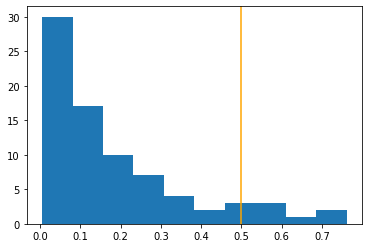

In [328]:
plt.hist(y_hat)
_ = plt.axvline(x=0.5, color='orange')

In [373]:
print(len(ydf[(ydf.y == 1) & (ydf.y_hat < 0.1)]))
print(len(y_test))

12
79


In [375]:
ydf[(ydf.y == 1) & (ydf.y_hat < 0.1)].head()

,y_hat,y
8,0.038521,1
9,0.060719,1
11,0.091632,1
22,0.054895,1
31,0.050390,1


In [ ]:
print(df.iloc[752])
print('Description:', df['Description'][752])
print('Prediction:', y_hat[8])
print("Reality:", y_test.iloc[8])

In [376]:
print(ydf[(ydf.y == 0) & (ydf.y_hat > 0.9)])
print(len(y_test))

Empty DataFrame
Columns: [y_hat, y]
Index: []
79


# Load/Save Model

In [304]:
model.save(output_dir+'/model_v002')

INFO:tensorflow:Assets written to: model_output/dense/model_v001/assets
